In [10]:
import argparse
from time import time

import numpy as np
from scipy.signal import windows

from DistantSpeech.adaptivefilter.FastFreqLms import FastFreqLms
from DistantSpeech.beamformer.MicArray import MicArray
from DistantSpeech.beamformer.beamformer import beamformer
from DistantSpeech.beamformer.utils import load_audio as audioread
from DistantSpeech.beamformer.utils import save_audio as audiowrite
from DistantSpeech.beamformer.utils import visual
from DistantSpeech.transform.transform import Transform
from DistantSpeech.noise_estimation import McSpp
from DistantSpeech.beamformer.FDGSC import FDGSC, DelayObj

import librosa
import matplotlib.pyplot as plt
from DistantSpeech.transform.transform import Transform
from DistantSpeech.beamformer.utils import pmesh, mesh, load_wav, save_audio, load_pcm, pt
from DistantSpeech.beamformer.utils import load_audio as audioread
from DistantSpeech.beamformer.utils import save_audio as audiowrite
from DistantSpeech.beamformer.beamformer import beamformer
from DistantSpeech.beamformer.fixedbeamformer import FixedBeamformer
from DistantSpeech.beamformer.MicArray import MicArray, compute_tau
from DistantSpeech.noise_estimation import McSpp

[[ 0.1   0.    0.  ]
 [ 0.05  0.    0.  ]
 [-0.    0.    0.  ]
 [-0.05  0.    0.  ]
 [-0.1   0.    0.  ]]
[2.5  1.75 0.5 ]
[3.3660254 2.        0.5      ]
The RT60 is 101 ms
(5, 96279)
(257, 376, 5)


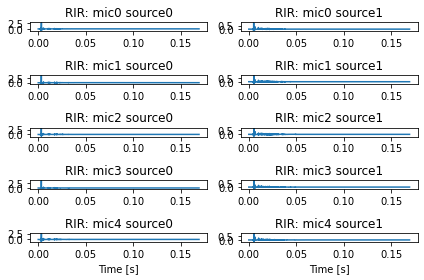

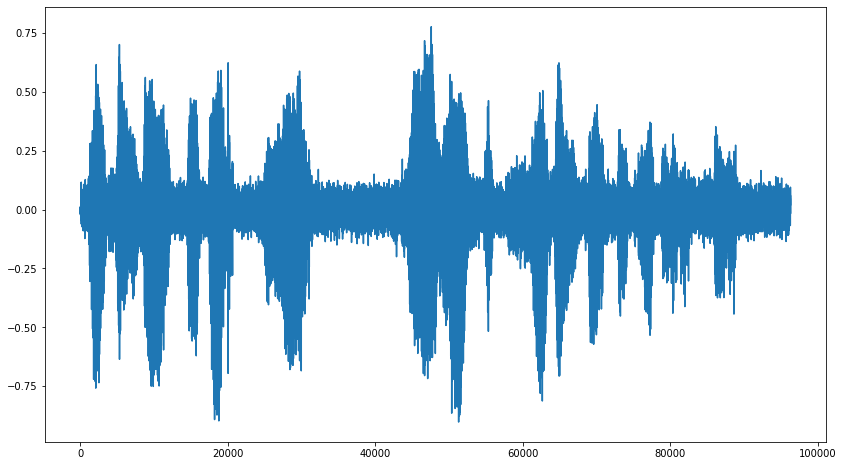

In [11]:
sampling_frequency = 16000
fft_length = 512
fft_shift = 256
mic_diameter = 0.05
sound_speed = 343
look_direction = 90
interf_angle = 30

signal = audioread("/home/wangwei/work/DistantSpeech/samples/audio_samples/5_541_20170608093550_3.wav")
signal = audioread("/home/wangwei/work/DistantSpeech/samples/audio_samples/5_541_20170608093550_5.wav")
# noise = audioread("/home/wangwei/work/DistantSpeech/samples/audio_samples/cleanspeech_aishell3.wav")
noise = audioread("/home/wangwei/work/DistantSpeech/samples/noise/office3.wav")

# signal = audioread("/home/wangwei/work/DistantSpeech/samples/audio_samples/5_541_20170608093550_4.wav")
# # signal = audioread("/home/wangwei/work/DistantSpeech/samples/audio_samples/cleanspeech_aishell3.wav")
# noise = audioread("/home/wangwei/work/DistantSpeech/samples/noise/office3.wav")

fs = 16000
M = 5
mic_array = MicArray(arrayType="linear", r=mic_diameter, M=M, n_fft=512, energy_absorption=0.55, room_size=[5.0,3.0,3.0])
print(mic_array.mic_loc)
mic_array_sim = mic_array.array_sim
# print(mic_array_sim.R)
array_data, premix = mic_array_sim.generate_audio(signal, interference=noise, source_angle=look_direction, interf_angle=interf_angle, sir=5, snr=20, source_distance=0.25, interf_distance=1.0)
theoretical=True
audiowrite('fixedbf/mix.wav', np.transpose(array_data))
audiowrite('fixedbf/signal.wav', np.transpose(premix[0, :, :]))
audiowrite('fixedbf/interf.wav', np.transpose(premix[1, :, :]))

# array_data = audioread('wpe/mix.wav')
# array_data = array_data.T

# array_data = load_pcm('/home/wangwei/work/DistantSpeech/example/wpe/pcm')
# array_data = load_pcm('/home/wangwei/work/DistantSpeech/example/wpe/10_nearend')

print(array_data.shape)
M = array_data.shape[0]
transform = Transform(n_fft=512, hop_length=256, channel=M)
D = transform.stft(np.transpose(array_data))
# transform = Transform(n_fft=512, hop_length=256, channel=M)
# target = transform.stft(np.transpose(premix[0, :M, :]))
# transform = Transform(n_fft=512, hop_length=256, channel=M)
# Noise = transform.stft(np.transpose(premix[1, :M, :]))
# print(Noise.shape)
half_bin = D.shape[0]
frame_num = D.shape[1]
print(D.shape)
# plt.figure(figsize=(14,8))
# plt.plot(mic_array_sim.room.rir[0][0][:10240])
# plt.show()
# array_data = array_data[:, :160000]
pt(array_data[0, :])

[[ 0.1   0.    0.  ]
 [ 0.05  0.    0.  ]
 [-0.    0.    0.  ]
 [-0.05  0.    0.  ]
 [-0.1   0.    0.  ]]


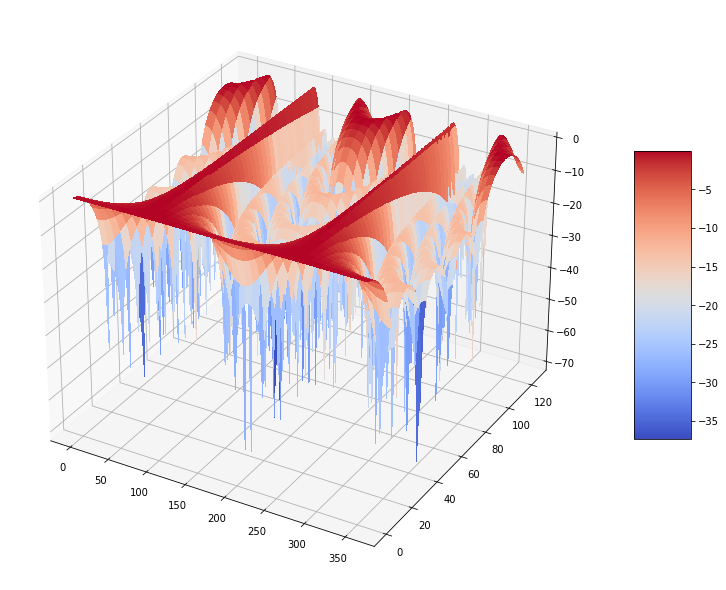

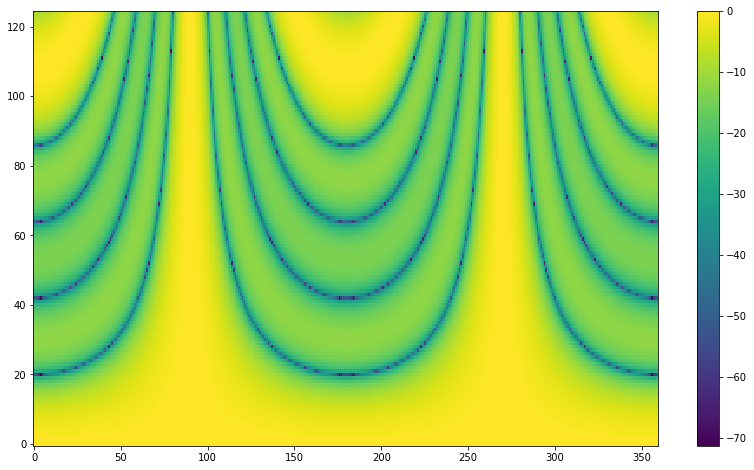

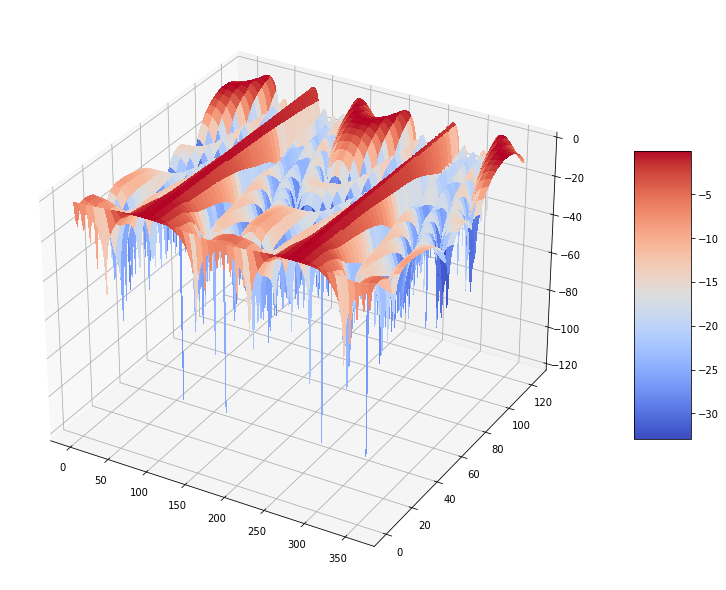

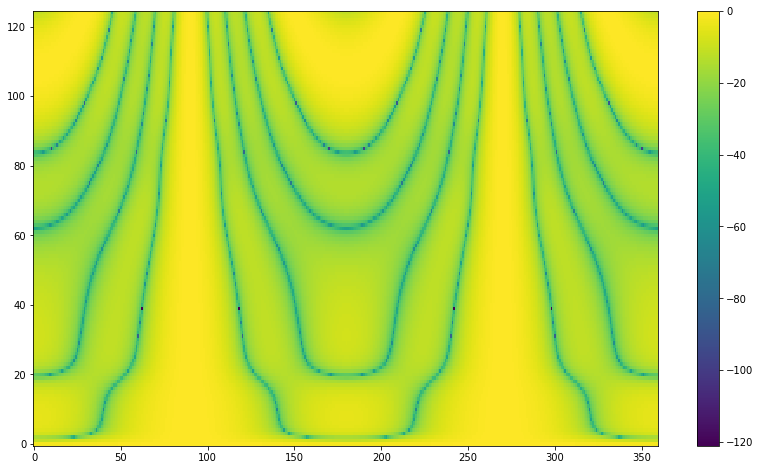

140210121491728
140212333010992


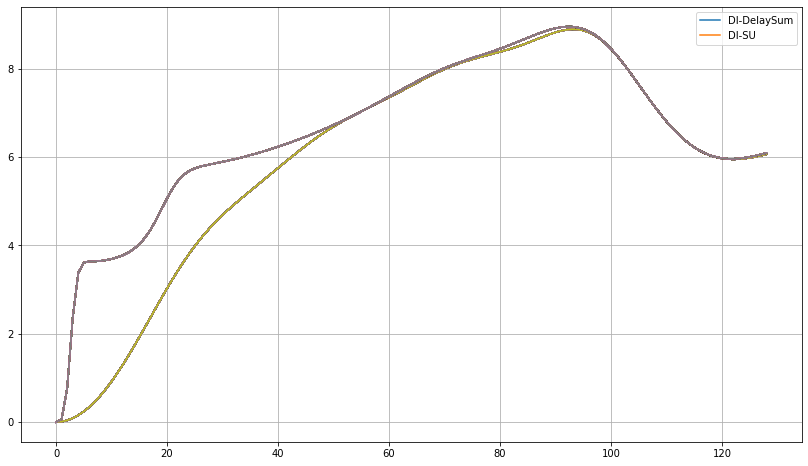

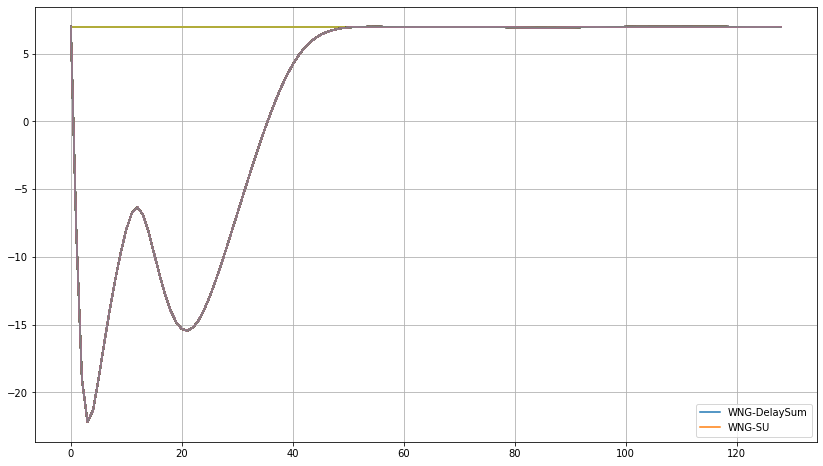

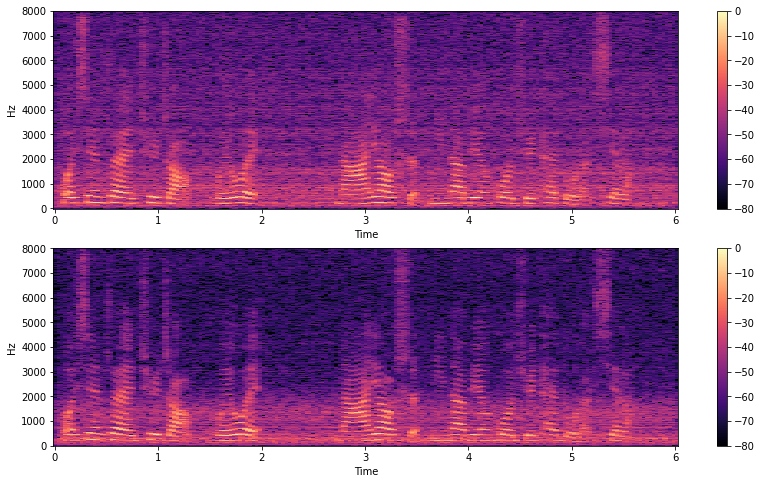

In [12]:
sr = 16000
r = 0.032
c = 343

frameLen = 256
hop = frameLen / 2
overlap = frameLen - hop
nfft = 256
c = 340
r = 0.05
fs = sr

MicArrayObj = MicArray(arrayType="linear", r=r, M=M)
print(MicArrayObj.mic_loc)
angle = [90, 0]

fixedbeamformerObj = FixedBeamformer(MicArrayObj, frameLen, hop, nfft, c, fs)

W = fixedbeamformerObj.compute_weights(angle, weightType='DS')
wng_ds, di_ds = fixedbeamformerObj.compute_wng_di(W, look_angle=angle)

W1 = fixedbeamformerObj.compute_weights(angle, weightType='SD', diag_value=1e-3)
wng_sd, di_sd = fixedbeamformerObj.compute_wng_di(W1, look_angle=angle)

beampattern = fixedbeamformerObj.compute_beampattern(MicArrayObj, weights=W.T)
mesh(beampattern[:, 2:-2].T)
pmesh(beampattern[:, 2:-2].T)

beampattern1 = fixedbeamformerObj.compute_beampattern(MicArrayObj, weights=W1.T)
mesh(beampattern1[:, 2:-2].T)
pmesh(beampattern1[:, 2:-2].T)

print(id(di_ds))
print(id(di_sd))

plt.figure(figsize=(14,8))
plt.plot(di_ds)
plt.plot(di_sd)
plt.grid()
plt.legend(['DI-DelaySum', 'DI-SU'])
plt.show()

plt.figure(figsize=(14,8))
plt.plot(wng_ds)
plt.plot(wng_sd)
plt.grid()
plt.legend(['WNG-DelaySum', 'WNG-SU'])
plt.show()

# x = np.random.rand(16000 * 5, M)
yout = fixedbeamformerObj.process(array_data.T, angle)
audiowrite('fixedbf/yout.wav', yout)
visual(array_data[0], yout)
